# 12. Manipulation de séries temporelles

Ce notebook permet de découvrir la manipulation des données temporelles avec l'écosystème pandas. Nous découvrirons quelques problématiques courantes lors de la manipulation de données temporelles (changement d'échelle de dates, enrichissement de données, sélection de données, ...).

Le dataset utilisé correspond au trafic automobile sur une route comportant plusieurs voies de circulation. Les trafics des différentes voies ont été agrégés en une valeur `flow`. L'attribut `velocity` indique la vitesse moyenne des véhicules sur toutes les voies. Deux colonnes indiquent si la mesure a été prise pendant un jour férié ou pendant une période de vacance scolaire.

In [1]:
import plotly
plotly.__version__

'5.24.1'

In [58]:
import plotly.express as px

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import plotly as py
import plotly.graph_objs as go
py.offline.init_notebook_mode(connected=True)

## 12.1 Chargement du dataset

Chargez le fichier `data/traffic-data.csv` dans une dataframe, puis :
1.  Affichez les types des colonnes du dataset
2.  Visualisez les 20 premières lignes et un échantillon pour intépréter les colonnes non numériques
3.  Affichez une description statistique des variables numériques
4.  Affichez un histogramme et un boxplot pour chaque **grandeur numérique**
5.  Affichez la matrice de corrélation entre ces grandeurs numériques
6.  Testez la significativité de la corrélation de pearson entre `flow` et `velocity` avec [`scipy.stats.pearsonr`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.pearsonr.html)

In [9]:
data = pd.read_csv('data/traffic-data.csv')

In [5]:
#1
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78946 entries, 0 to 78945
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   horodate        78946 non-null  object 
 1   flow            78946 non-null  float64
 2   occupation      78946 non-null  int64  
 3   velocity        78946 non-null  int64  
 4   date            78946 non-null  object 
 5   bank_holiday    78946 non-null  bool   
 6   school_holiday  78946 non-null  bool   
dtypes: bool(2), float64(1), int64(2), object(2)
memory usage: 3.2+ MB


In [6]:
#2
data.head(20)

horodate   flow  occupation  velocity        date  \
0   2017-10-31 23:06:00  171.0           0       123  2017-10-31   
1   2017-10-31 23:12:00   71.0           0       113  2017-10-31   
2   2017-10-31 23:18:00  101.0           0       136  2017-10-31   
3   2017-10-31 23:24:00  111.0           0       117  2017-10-31   
4   2017-10-31 23:30:00   51.0           0       116  2017-10-31   
5   2017-10-31 23:36:00   71.0           0       134  2017-10-31   
6   2017-10-31 23:42:00   91.0           0       139  2017-10-31   
7   2017-10-31 23:48:00   81.0           0       117  2017-10-31   
8   2017-10-31 23:54:00   91.0           0       116  2017-10-31   
9   2017-11-01 00:00:00   91.0           0       134  2017-11-01   
10  2017-11-01 00:06:00   41.0           0       128  2017-11-01   
11  2017-11-01 00:12:00   11.0           0        99  2017-11-01   
12  2017-11-01 00:18:00   11.0           0       130  2017-11-01   
13  2017-11-01 00:24:00   51.0           0       103  2017-11-01   
14  2017-11-01 00:30:00   11.0           0       128  2017-11-01   
15  2017-11-01 00:36:00   21.0           0       137  2017-11-01   
16  2017-11-01 00:42:00   51.0           0       138  2017-11-01   
17  2017-11-01 00:48:00   51.0           0       116  2017-11-01   
18  2017-11-01 00:54:00   71.0           0       117  2017-11-01   
19  2017-11-01 01:00:00   31.0           0        94  2017-11-01   

    bank_holiday  school_holiday  
0          False            True  
1          False            True  
2          False            True  
3          False            True  
4          False            True  
5          False            True  
6          False            True  
7          False            True  
8          False            True  
9           True            True  
10          True            True  
11          True            True  
12          True            True  
13          True            True  
14          True            True  
15          True            True  
16          True            True  
17          True            True  
18          True            True  
19          True            True

In [7]:
#3
data.describe()

flow    occupation      velocity
count  78946.000000  78946.000000  78946.000000
mean     267.484306      3.085020    104.222291
std      246.207618      7.770133     38.130696
min        1.000000      0.000000      0.000000
25%       71.000000      0.000000    104.000000
50%      201.000000      2.000000    119.000000
75%      401.000000      2.000000    126.000000
max     3191.000000    116.000000    250.000000

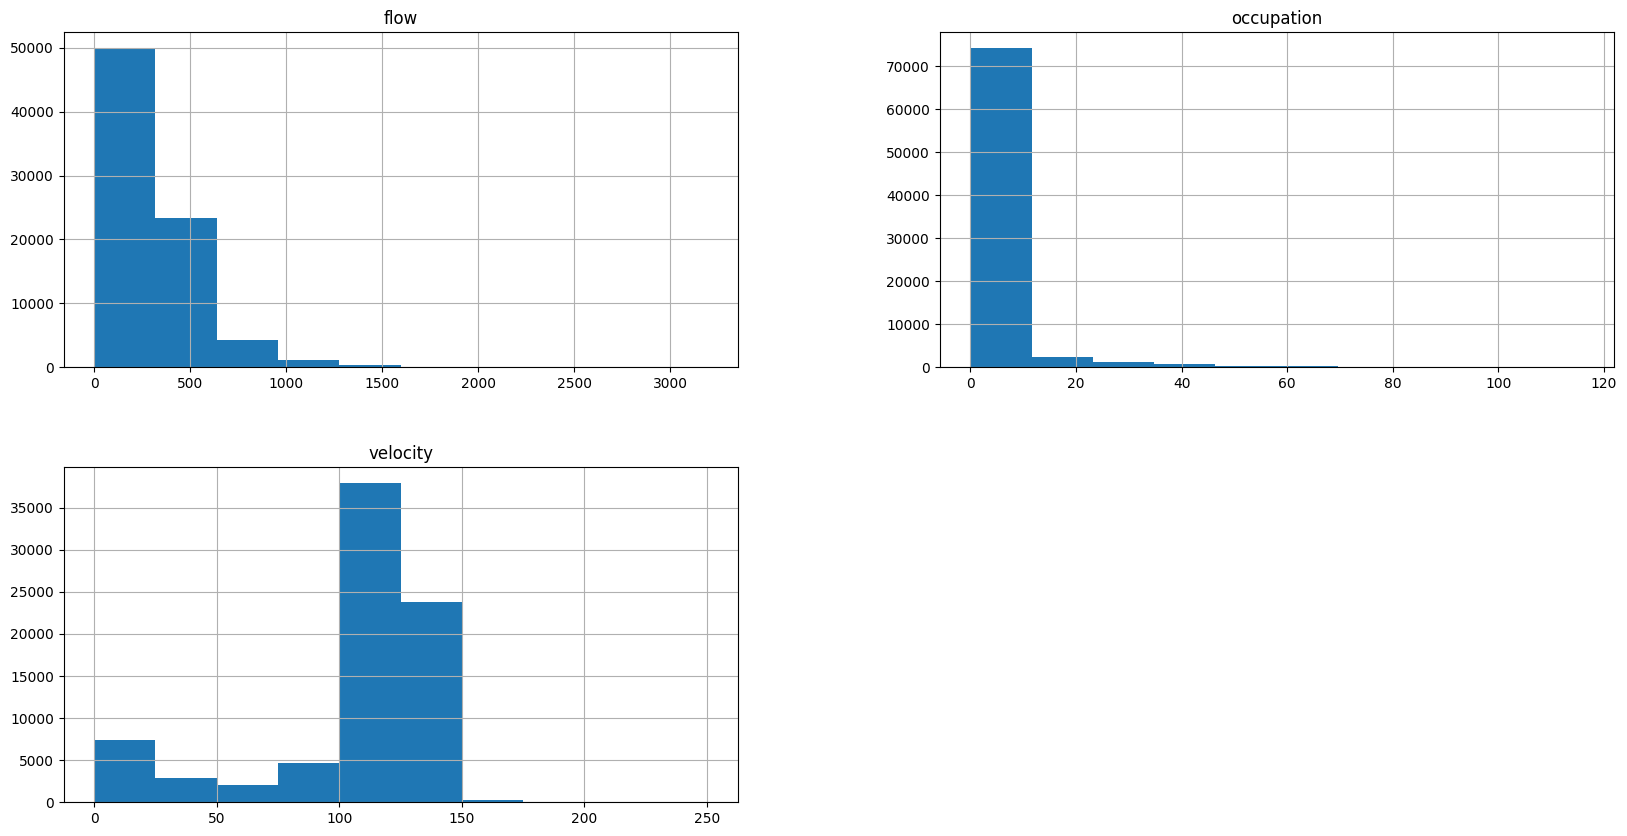

In [8]:
#4.1
data[['flow', 'occupation', 'velocity']].hist(figsize=(20, 10))
plt.show()

<Axes: >

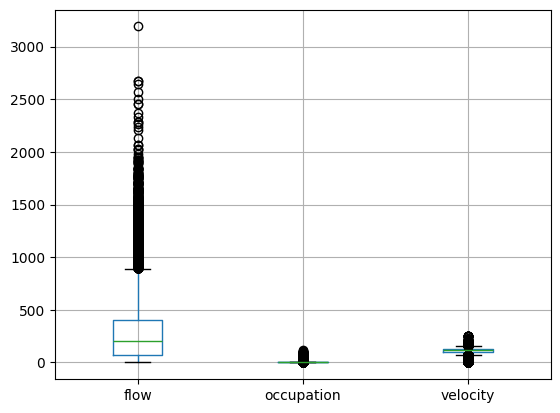

In [10]:
#4.2
data[['flow', 'occupation', 'velocity']].boxplot()

In [11]:
#5
data[['flow','occupation', 'velocity']].corr(method='pearson')

flow  occupation  velocity
flow        1.000000   -0.046454  0.209553
occupation -0.046454    1.000000 -0.400824
velocity    0.209553   -0.400824  1.000000

In [12]:
#6
from scipy.stats import pearsonr
pearsonr(data.flow, data.velocity)

PearsonRResult(statistic=0.20955265656666483, pvalue=0.0)

## 12.2 Manipulation des dates

Il existe de nombreux formats pour les valeurs de temps (timestamps) : Timestamps numpy et datetime en particulier. Jouons un peu avec ces formats :

A l'aide du module [`time`](https://docs.python.org/3/library/time.html), définissez une variable `current_time` calculée au moment de l'exécution. Puis utilisez la méthode [`strftime`](https://docs.python.org/3/library/datetime.html#datetime.date.strftime) pour la convertir sous la forme d'une chaîne de caractère au format `YYYY-MM-DD HH:mm:ss` et stockez cette chaine dans une variable :

In [13]:
import time

current_time = time.localtime()
str_current_time = time.strftime("%Y-%m-%d %H:%M:%S", current_time)
print(str_current_time)

2024-11-01 15:45:25


Convertissez cette chaîne de caractère au format `np.datetime64` :

In [14]:
np_current_time = np.datetime64(str_current_time)
np_current_time

numpy.datetime64('2024-11-01T15:45:25')

Utilisez la méthode [`datetime.datetime.strptime`](https://docs.python.org/3/library/datetime.html#datetime.datetime.strptime) du package `datetime` pour parser la date qui est sous forme de chaîne de caractères en datetime.
*Vous devriez obtenir un resultat du type ```datetime(Y, M, D, H, m, s, ms)```*

In [15]:
from datetime import datetime as dt
dt.strptime(str_current_time, "%Y-%m-%d %H:%M:%S")

datetime.datetime(2024, 11, 1, 15, 45, 25)

Transformez la date depuis le format numpy vers le format datetime et retrouvez le même résultat trouvé à la question précédente.

In [16]:
dt.strptime(str(np_current_time), "%Y-%m-%dT%H:%M:%S")

datetime.datetime(2024, 11, 1, 15, 45, 25)

Le format de données [`datetime`](https://docs.python.org/3/library/datetime.html#datetime-objects) est le plus riche : il offre le plus de fonctionnalités, comme l'accès à certains attributs très utiles pour les dates : année, mois, semaine dans le calendrier annuel, jour de la semaine... Pour pouvoir en tirer parti, il faut convertir nos horodates en datetime. Convertissez la colonne `horodate` en datetime en utilisant la fonction [`pandas.to_datetime`](https://pandas.pydata.org/docs/reference/api/pandas.to_datetime.html) :

In [17]:
data['horodate'] = pd.to_datetime(data.horodate)

Ajoutez à votre dataframe une colonne pour chaque attribut :
- l'année
- le mois
- la date (YYYY-MM-DD)
- le jour de la semaine
- l'heure
- la minute

Vérifiez le résultat obtenu.

In [18]:
data['year'] = data['horodate'].dt.year
data['month'] = data['horodate'].dt.month
data['date'] = data['horodate'].dt.date
data['weekday'] = data['horodate'].dt.weekday
data['hour'] = data['horodate'].dt.hour
data['minute'] = data['horodate'].dt.minute

In [19]:
data

horodate   flow  occupation  velocity        date  \
0     2017-10-31 23:06:00  171.0           0       123  2017-10-31   
1     2017-10-31 23:12:00   71.0           0       113  2017-10-31   
2     2017-10-31 23:18:00  101.0           0       136  2017-10-31   
3     2017-10-31 23:24:00  111.0           0       117  2017-10-31   
4     2017-10-31 23:30:00   51.0           0       116  2017-10-31   
...                   ...    ...         ...       ...         ...   
78941 2018-09-25 21:30:00   51.0           0       109  2018-09-25   
78942 2018-09-25 21:36:00   31.0           0       117  2018-09-25   
78943 2018-09-25 21:42:00  121.0           2       107  2018-09-25   
78944 2018-09-25 21:48:00   21.0           0        93  2018-09-25   
78945 2018-09-25 21:54:00   21.0           0       133  2018-09-25   

       bank_holiday  school_holiday  year  month  weekday  hour  minute  
0             False            True  2017     10        1    23       6  
1             False            True  2017     10        1    23      12  
2             False            True  2017     10        1    23      18  
3             False            True  2017     10        1    23      24  
4             False            True  2017     10        1    23      30  
...             ...             ...   ...    ...      ...   ...     ...  
78941         False           False  2018      9        1    21      30  
78942         False           False  2018      9        1    21      36  
78943         False           False  2018      9        1    21      42  
78944         False           False  2018      9        1    21      48  
78945         False           False  2018      9        1    21      54  

[78946 rows x 12 columns]

## 12.3 Vérification de la complétion temporelle de la série

Une série temporelle possède une fréquence $F$ : toutes les $F$ secondes, une valeur doit être présente dans les données.
Il peut arriver qu'une série temporelle soit incomplète. Deux cas peuvent expliquer cela :
1. Absence d'enregistrement à une horodate donnée donnant lieu à un tuple manquant.
2. Absence de données due au changement d'horaire. En effet, les séries temporelles sont souvent exprimées sur l'échelle de temps UTC, qui est une échelle universelle. Les échelles de temps locales sont généralement décalées par rapport à UTC et la valeur de ce décalage change avec le changement d'heure hiverna/estival.

Or pour certains usages (ex. pour la prédiction de trafic), les régularités de trafic s'observent non pas en UTC, mais en temps local.

Il est donc nécessaire de convertir des données UTC en localtime, ce qui genère des trous et des redondances dans les données...

Trouvez les dates de début et de fin du dataset et calculez l'extension temporelle correspondante :

In [20]:
start = data.horodate.min()
end = data.horodate.max()

timerange = end -start
timerange

Timedelta('328 days 22:48:00')

Pour convertir les datetime UTC en dates locales (CET), nous pouvons utiliser Pandas ou la librairire [pytz](https://pypi.org/project/pytz/).

Une datetime est par défaut sans timezone (timezone naive). Il faut donc dans un premier temps convertir notre datetime en timezone aware puis la convertir dans la timezone cible.

Notez la présence de la timezone dans l'affichage de la nouvelle datetime et la conversion en temps local dans la sortie du formattage de cette datetime.

In [24]:
import pytz

mydt = dt(2018, 5, 25, 15, 12, 30)
cet_tz = pytz.timezone('CET')
mydt_utc = pytz.utc.localize(mydt)
print("Datetime format UTC:", mydt_utc)
mydt_cet = mydt_utc.astimezone(cet_tz)
print("Datetime format CET:", mydt_cet)
print("Datetime format string:", mydt.strftime("%Y-%m-%d %H:%M:%S"))
decalage = cet_tz.utcoffset(mydt)
print("Décalage entre UTC et CET (en heure):", decalage)

Datetime format UTC: 2018-05-25 15:12:30+00:00
Datetime format CET: 2018-05-25 17:12:30+02:00
Datetime format string: 2018-05-25 15:12:30
Décalage entre UTC et CET (en heure): 2:00:00


Créez une fonction `convert_utc_to_cet` prenant en paramètre une datetime et renvoyant cette datetime dans la timezone CET, puis créez une nouvelle colonne `localtime_horodate` dans votre dataframe en utilisant la méthode [`pandas.Series.apply`](https://pandas.pydata.org/docs/reference/api/pandas.Series.apply.html) sur la colonne `horodate` :

In [25]:
def convert_utc_to_localtime(date):
    cet_tz = pytz.timezone('CET')
    return pytz.utc.localize(date).astimezone(cet_tz)

In [26]:
data['localtime_horodate'] = data.horodate.apply(convert_utc_to_localtime)

In [27]:
data

horodate   flow  occupation  velocity        date  \
0     2017-10-31 23:06:00  171.0           0       123  2017-10-31   
1     2017-10-31 23:12:00   71.0           0       113  2017-10-31   
2     2017-10-31 23:18:00  101.0           0       136  2017-10-31   
3     2017-10-31 23:24:00  111.0           0       117  2017-10-31   
4     2017-10-31 23:30:00   51.0           0       116  2017-10-31   
...                   ...    ...         ...       ...         ...   
78941 2018-09-25 21:30:00   51.0           0       109  2018-09-25   
78942 2018-09-25 21:36:00   31.0           0       117  2018-09-25   
78943 2018-09-25 21:42:00  121.0           2       107  2018-09-25   
78944 2018-09-25 21:48:00   21.0           0        93  2018-09-25   
78945 2018-09-25 21:54:00   21.0           0       133  2018-09-25   

       bank_holiday  school_holiday  year  month  weekday  hour  minute  \
0             False            True  2017     10        1    23       6   
1             False            True  2017     10        1    23      12   
2             False            True  2017     10        1    23      18   
3             False            True  2017     10        1    23      24   
4             False            True  2017     10        1    23      30   
...             ...             ...   ...    ...      ...   ...     ...   
78941         False           False  2018      9        1    21      30   
78942         False           False  2018      9        1    21      36   
78943         False           False  2018      9        1    21      42   
78944         False           False  2018      9        1    21      48   
78945         False           False  2018      9        1    21      54   

             localtime_horodate  
0     2017-11-01 00:06:00+01:00  
1     2017-11-01 00:12:00+01:00  
2     2017-11-01 00:18:00+01:00  
3     2017-11-01 00:24:00+01:00  
4     2017-11-01 00:30:00+01:00  
...                         ...  
78941 2018-09-25 23:30:00+02:00  
78942 2018-09-25 23:36:00+02:00  
78943 2018-09-25 23:42:00+02:00  
78944 2018-09-25 23:48:00+02:00  
78945 2018-09-25 23:54:00+02:00  

[78946 rows x 13 columns]

Est-ce que cette méthode prend en compte les changements d'heures d'été/d'hiver ?

*Le dernier dimanche de mars 2018 correspond à 25/03/2018*

In [28]:
data[(data.localtime_horodate >= '2018-03-25') & (data.localtime_horodate <= '2018-03-26')]

horodate   flow  occupation  velocity        date  \
34556 2018-03-24 23:00:00   61.0           0       130  2018-03-24   
34557 2018-03-24 23:06:00   61.0           0       125  2018-03-24   
34558 2018-03-24 23:12:00   81.0           0       139  2018-03-24   
34559 2018-03-24 23:18:00   71.0           0       124  2018-03-24   
34560 2018-03-24 23:24:00   91.0           0       119  2018-03-24   
...                   ...    ...         ...       ...         ...   
34782 2018-03-25 21:36:00   51.0           0       124  2018-03-25   
34783 2018-03-25 21:42:00   81.0           0       132  2018-03-25   
34784 2018-03-25 21:48:00  131.0           0       128  2018-03-25   
34785 2018-03-25 21:54:00   21.0           0       100  2018-03-25   
34786 2018-03-25 22:00:00   71.0           0       117  2018-03-25   

       bank_holiday  school_holiday  year  month  weekday  hour  minute  \
34556         False           False  2018      3        5    23       0   
34557         False           False  2018      3        5    23       6   
34558         False           False  2018      3        5    23      12   
34559         False           False  2018      3        5    23      18   
34560         False           False  2018      3        5    23      24   
...             ...             ...   ...    ...      ...   ...     ...   
34782         False           False  2018      3        6    21      36   
34783         False           False  2018      3        6    21      42   
34784         False           False  2018      3        6    21      48   
34785         False           False  2018      3        6    21      54   
34786         False           False  2018      3        6    22       0   

             localtime_horodate  
34556 2018-03-25 00:00:00+01:00  
34557 2018-03-25 00:06:00+01:00  
34558 2018-03-25 00:12:00+01:00  
34559 2018-03-25 00:18:00+01:00  
34560 2018-03-25 00:24:00+01:00  
...                         ...  
34782 2018-03-25 23:36:00+02:00  
34783 2018-03-25 23:42:00+02:00  
34784 2018-03-25 23:48:00+02:00  
34785 2018-03-25 23:54:00+02:00  
34786 2018-03-26 00:00:00+02:00  

[231 rows x 13 columns]

Pour rechercher les horodates manquantes dans la série temporelle indexée sur le temps local, nous pouvons générer la liste complète des horodates à la **fréquence de 6 minutes** entre le premier et le dernier horodate en temps local.

Utilisez [`pandas.date_range`](https://pandas.pydata.org/docs/reference/api/pandas.date_range.html) pour obtenir la liste des timestamps sur la plage de temps considérée, puis créez une dataframe contenant une seule colonne avec cette liste :

In [31]:
complete_horodates = pd.date_range(convert_utc_to_localtime(start), convert_utc_to_localtime(end), freq='6min')
complete_horodates

DatetimeIndex(['2017-11-01 00:06:00+01:00', '2017-11-01 00:12:00+01:00',
               '2017-11-01 00:18:00+01:00', '2017-11-01 00:24:00+01:00',
               '2017-11-01 00:30:00+01:00', '2017-11-01 00:36:00+01:00',
               '2017-11-01 00:42:00+01:00', '2017-11-01 00:48:00+01:00',
               '2017-11-01 00:54:00+01:00', '2017-11-01 01:00:00+01:00',
               ...
               '2018-09-25 23:00:00+02:00', '2018-09-25 23:06:00+02:00',
               '2018-09-25 23:12:00+02:00', '2018-09-25 23:18:00+02:00',
               '2018-09-25 23:24:00+02:00', '2018-09-25 23:30:00+02:00',
               '2018-09-25 23:36:00+02:00', '2018-09-25 23:42:00+02:00',
               '2018-09-25 23:48:00+02:00', '2018-09-25 23:54:00+02:00'],
              dtype='datetime64[ns, CET]', length=78949, freq='6min')

Réalisez une jointure avec [`pandas.merge`](https://pandas.pydata.org/docs/reference/api/pandas.merge.html) entre cette dataframe et notre dataframe contenant toutes les données.

*Faites attention à bien choisir le bon type de jointure via le paramètre ```how```. Sachant que nous souhaitons conserver la liste des dates complètes.*

In [32]:
complete_tr = pd.DataFrame(data={'localtime_horodate_complete': complete_horodates})
data = data.merge(complete_tr,
                  left_on='localtime_horodate',
                  right_on='localtime_horodate_complete', how='right')

Identifiez les tuples correspondant à des horodates manquantes dans le dataset et déterminez la cause probable pour ces manquants :

In [33]:
rows_with_missing_values = data.loc[data.horodate.isna()].index
data.iloc[rows_with_missing_values]

horodate  flow  occupation  velocity date bank_holiday school_holiday  \
12154      NaT   NaN         NaN       NaN  NaN          NaN            NaN   
24834      NaT   NaN         NaN       NaN  NaN          NaN            NaN   
24835      NaT   NaN         NaN       NaN  NaN          NaN            NaN   

       year  month  weekday  hour  minute localtime_horodate  \
12154   NaN    NaN      NaN   NaN     NaN                NaT   
24834   NaN    NaN      NaN   NaN     NaN                NaT   
24835   NaN    NaN      NaN   NaN     NaN                NaT   

      localtime_horodate_complete  
12154   2017-12-21 15:30:00+01:00  
24834   2018-02-12 11:30:00+01:00  
24835   2018-02-12 11:36:00+01:00

## 12.4 Correction des valeurs (valeurs décalées et manquantes)

Nous allons remplacer ces valeurs manquantes par la valeur pour le même jour la semaine suivante. Nous pourrions aussi recourir à la méthode `interpolate` pour réaliser une interpolation des valeurs manquantes entre deux valeurs présentes.

Commencez par appliquez la méthode [`pandas.DataFrame.shift`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.shift.html) sur les colonnes `flow` et `velocity` pour obtenir un décalage d'une semaine :

In [34]:
data['flow'].shift(10 * 24 * 7)

0         NaN
1         NaN
2         NaN
3         NaN
4         NaN
         ... 
78944    61.0
78945    41.0
78946    31.0
78947    61.0
78948    51.0
Name: flow, Length: 78949, dtype: float64

Utilisez la méthode [`pandas.DataFrame.fillna`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.fillna.html) pour remplacer les valeurs manquantes en utilisant les valeurs de la semaine suivante pour les colonnes `flow` et `velocity` :

In [35]:
data['flow'] = data.flow.fillna(data.flow.shift(10 * 24 * 7))
data['velocity'] = data.velocity.fillna(data.flow.shift(10 * 24 * 7))

Affichez les valeurs que nous venont d'imputer :

In [36]:
data.iloc[rows_with_missing_values]

horodate   flow  occupation  velocity date bank_holiday school_holiday  \
12154      NaT  291.0         NaN     291.0  NaN          NaN            NaN   
24834      NaT   11.0         NaN      11.0  NaN          NaN            NaN   
24835      NaT   41.0         NaN      41.0  NaN          NaN            NaN   

       year  month  weekday  hour  minute localtime_horodate  \
12154   NaN    NaN      NaN   NaN     NaN                NaT   
24834   NaN    NaN      NaN   NaN     NaN                NaT   
24835   NaN    NaN      NaN   NaN     NaN                NaT   

      localtime_horodate_complete  
12154   2017-12-21 15:30:00+01:00  
24834   2018-02-12 11:30:00+01:00  
24835   2018-02-12 11:36:00+01:00

Recréez les colonnes indiquant l'année, le mois, la date (YYYY-MM-DD), le jour de la semaine, l'heure, la minute depuis la colonnes `localtime_horodate_complete` pour obtenir ces valeurs en timezone CET et quelles soient présentes pour toutes les lignes :

In [37]:
data['year'] = data['localtime_horodate_complete'].dt.year
data['month'] = data['localtime_horodate_complete'].dt.month
data['date'] = data['localtime_horodate_complete'].dt.date
data['weekday'] = data['localtime_horodate_complete'].dt.weekday
data['hour'] = data['localtime_horodate_complete'].dt.hour
data['minute'] = data['localtime_horodate_complete'].dt.minute

In [38]:
data.iloc[rows_with_missing_values]

horodate   flow  occupation  velocity        date bank_holiday  \
12154      NaT  291.0         NaN     291.0  2017-12-21          NaN   
24834      NaT   11.0         NaN      11.0  2018-02-12          NaN   
24835      NaT   41.0         NaN      41.0  2018-02-12          NaN   

      school_holiday  year  month  weekday  hour  minute localtime_horodate  \
12154            NaN  2017     12        3    15      30                NaT   
24834            NaN  2018      2        0    11      30                NaT   
24835            NaN  2018      2        0    11      36                NaT   

      localtime_horodate_complete  
12154   2017-12-21 15:30:00+01:00  
24834   2018-02-12 11:30:00+01:00  
24835   2018-02-12 11:36:00+01:00

Analysez le code suivant, décrivez son fonctionnement et le résultat obtenu (pensez à utiliser des affichages intermédiaires des différentes étapes) :

In [39]:
data_mode_per_day = data[['date', 'bank_holiday', 'school_holiday']].groupby('date').agg(pd.Series.mode).reset_index()
data_mode_per_day.date = data_mode_per_day.date.astype(str)
data.date = data.date.astype(str)
data = data.merge(
    data_mode_per_day,
    on='date',
    suffixes=('', '_imputation_value'),
    how='left'
)
for column in ['bank_holiday', 'school_holiday']:
    data[column] = data['{}_imputation_value'.format(column)]

In [40]:
data_mode_per_day

date  bank_holiday  school_holiday
0    2017-11-01          True            True
1    2017-11-02         False            True
2    2017-11-03         False            True
3    2017-11-04         False            True
4    2017-11-05         False            True
..          ...           ...             ...
324  2018-09-21         False           False
325  2018-09-22         False           False
326  2018-09-23         False           False
327  2018-09-24         False           False
328  2018-09-25         False           False

[329 rows x 3 columns]

Quelles sont les limites de la méthode d'imputation que vous avez appliqué ?

Supprimez les colonnes inutiles (`horodate`, `bank_holiday_imputation_value` et `school_holiday_imputation_value`) :

In [41]:
data = data.drop(columns=['horodate', 'bank_holiday_imputation_value', 'school_holiday_imputation_value'])

## 12.5 Identification des dates en doublon

Y a-t-il des des doublons sur l'horodate local ? S'il y en a, supprimez les.

In [42]:
data[data.duplicated(subset=['localtime_horodate_complete'])]

Empty DataFrame
Columns: [flow, occupation, velocity, date, bank_holiday, school_holiday, year, month, weekday, hour, minute, localtime_horodate, localtime_horodate_complete]
Index: []

## 12.6 Manipulation des données

Pour effectuer des analyses temporelles sur les données, il est souvent pratique d'indéxer la dataframe sur les horodates. Ré-indexez votre dataframe avec la colonne de l'horodate locale :

In [43]:
data.set_index("localtime_horodate_complete", inplace=True)

### 12.6.1 Analyse de la saisonnalité des données

Utilisez la fonction [`pandas.plotting.autocorrelation_plot`](https://pandas.pydata.org/docs/reference/api/pandas.plotting.autocorrelation_plot.html) pour afficher le diagramme d'autocorrélation du trafic (```flow```) et/ou utilisez la fonction `plot_autocorrelation_lags` définie ci-dessous.

Puis expliquez ce diagramme d'autocorrélation, les données sont-elles saisonnières ?

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

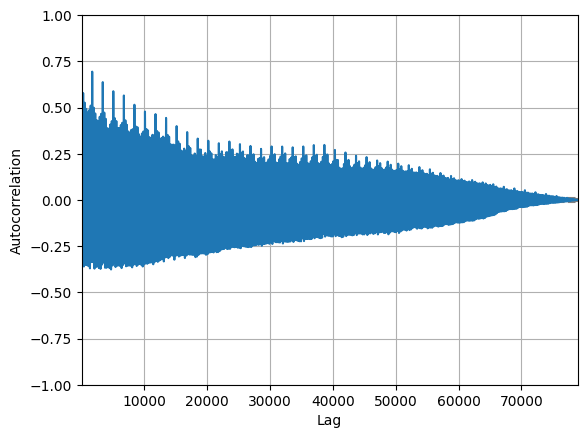

In [44]:
pd.plotting.autocorrelation_plot(data.flow)

In [56]:
from scipy import signal

def plot_autocorrelation_lags(s):
    corr = signal.correlate(s - s.mean(), s - s.mean())
    corr /= np.max(corr)
    corr = corr[len(s):]

    fig = px.scatter(corr)

    fig.show(renderer='colab')

In [57]:
plot_autocorrelation_lags(data.flow)

### 12.6.2 Rééchantillonnage des données

Avec pandas, certaines opérations sur les séries temporelles sont très simplifiées, comme le rééchantillonnage.

Rééchantillonnez le dataset avec une fréquence de 12min (créez une dataframe `data_12`) et 24 min (`data_24`) en utilisant la méthode [`pandas.DataFrame.resample`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.resample.html), vous devez choisir une méthode d'aggrégation adaptée (pour les colonnes flow, occupation et velocity uniquement) :

In [50]:
data_12 = data.resample('12min').agg(
    {
        'flow': "sum",
        'occupation': lambda x: pd.Series.mode(x)[0],
        'velocity': "mean"
    }
)
data_24 = data.resample('24min').agg(
    {
        'flow': "sum",
        'occupation': lambda x: pd.Series.mode(x)[0],
        'velocity': "mean"
    }
)

Affichez les données de trafic (`flow`) avec la fonction [`line`](https://plotly.com/python/line-charts/)plotly express pour les 3 premiers jours de `data`, `data_12` et `data_24`. Que remarquez-vous quant à l'effet du resampling ?

In [52]:
fig = px.line(data[data.index < '2017-11-08'], y='flow')
fig.show(renderer='colab')

In [59]:
fig = px.line(data_12[data_12.index < '2017-11-08'], y='flow')
fig.show(renderer='colab')

In [61]:
fig = px.line(data_24[data_24.index < '2017-11-08'], y='flow')
fig.show(renderer='colab')

### 12.6.3 Simplification des données

Simplifions les données en ne retenant que le trafic pour les mardis. Créez une dataframe `data_tuesday` ne contenant que les mardis, affichez l'autocorrélogramme du trafic et comparez le résultat obtenu avec celui obtenu sur tout le dataset :

In [63]:
data_tuesday = data.loc[data.weekday == 1]
plot_autocorrelation_lags(data_tuesday.flow)

Affichez les courbes de trafic pour tous les mardis de notre dataset avec `px.line`. Pour obtenir le meilleur affichage possible :
* appelez la méthode `update_xaxes` sur votre figure, après l'avoir créé et avant de l'afficher, en utilisant le paremètre `rangebreaks=[{'bounds': ["wed", "tues"]}]` pour cacher les sauts de dates
* utiliser le paramètre `render_mode="svg"` pour l'appel à `px.line` (pour éviter un bug connu de plotly sur l'affichage d'un graphique avec un saut de dates et le moteur de rendu WebGL)

Remarquez-vous des particularités ?

In [64]:
fig = px.line(data_tuesday, y='flow', render_mode="svg")
fig.update_xaxes(rangebreaks=[{'bounds': ["wed", "tues"]}])
fig.show(renderer='colab')

### 12.6.4 Détection des outliers

On considère mettre en œuvre un modèle prédictif linéaire pour les données de trafic du dataset. D'après le graphique ci-dessus, les données ne sont pas très qualitatives...

**Identifiez deux problèmes dans ces données.**

L'unité de détection des anomalies doit respecter la saisonnalité, soit dans cette série simplifiée, la journée.

Pour détecter (et éliminer) les jours où les données sont de mauvaise qualité, nous proposons d'utiliser la décomposition .

L'idée est la suivante :
- On effectue une décomposition
- Les valeurs de tendance, de saisonnalité et de résidu à chaque horodate peuvent être considérées comme des attributs
- On cherche les anomalies dans l'espace de ces attributs au moyen d'un algorithme d'identification d'outliers, par ex. IsolationTrees
- On devra alors rejeter les jours contenant trop d'horodates 'outlier' selon cet algorithme.

#### 12.6.4.1 Décomposition

Réalisez une décomposition du trafic avec la fonction [`statsmodels.tsa.seasonal.seasonal_decompose`](https://www.statsmodels.org/dev/generated/statsmodels.tsa.seasonal.seasonal_decompose.html) avec les paramètres suivants :
* `x=df.flow.values` : essayez de passer directement `df.flow` puis commentez
* `model='additive'` : comparez `additive` et `multiplicative`
* `period: int` : trouvez la bonne valeur
* `extrapolate_trend=True` : pour obtenir une trend sur toute la série observée

Puis affichez les valeurs des attributs résultant de la décomposition.

In [65]:
import statsmodels
statsmodels.__version__

'0.14.4'

In [66]:
from statsmodels.tsa.seasonal import seasonal_decompose

df = data_tuesday.copy()

st_result = seasonal_decompose(
    df.flow.values,
    model="additive",
    period=24*10,
    extrapolate_trend=True
)

Affichez les graphiques de cette décomposition en utilisant la méthode `plot` sur le résultat de la décomposition. Vous pouvez afficher un graphique plus lisible en utilisant les instructions `fig.set_size_inches((16, 9))` et `fig.tight_layout()` (prenez soin d'affecter le résultat de l'appel à `plot` dans une variable nommée `fig`) :

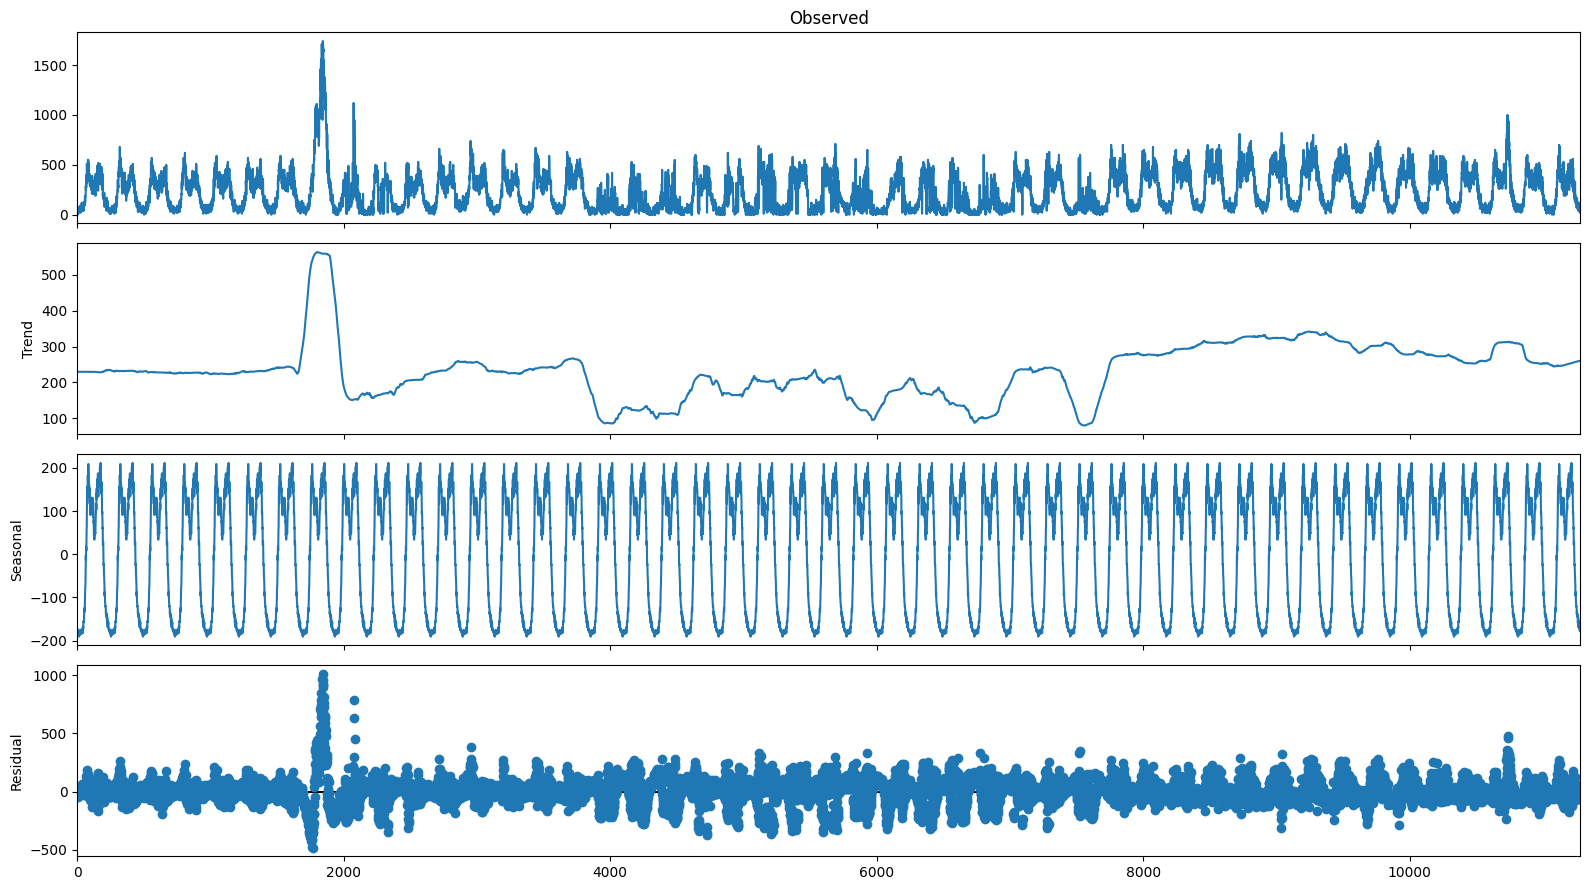

In [70]:
fig = st_result.plot()
fig.set_size_inches((16, 9))
fig.tight_layout()

Créez des colonnes dans votre dataframe contenant les valeurs de saisonnalité, de tendance et de résidu de notre décomposition pour chaque ligne :

In [71]:
df['seasonal'] = st_result.seasonal
df['trend'] = st_result.trend
df['resid'] = st_result.resid

#### 12.6.4.2 Recherche des outliers

Entrainez un modèle [`sklearn.ensemble.IsolationForest`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html) sur la résidu de la décomposition en précisant comme paramètre lors de la création de l'instance `contamination=.2`. Puis réalisez une prédiction sur sur ce même résidu, interprétez le résultat et affectez le à une colonne `valid_value` de votre dataframe :

In [72]:
from sklearn.ensemble import IsolationForest

model = IsolationForest(contamination=.2)
df['valid_value'] = model.fit_predict(df[['resid']].values)

<Axes: >

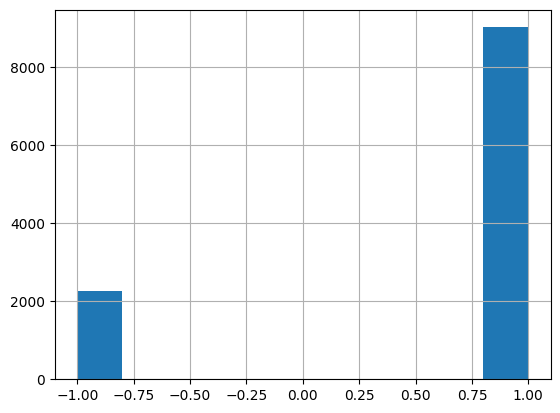

In [73]:
df.valid_value.hist()

Créez une series contenant la somme des `valid_value` par jour puis ajoutez une colonne (nommée `valid_value_sum`) indiquant la valeur de cette somme pour chaque ligne (indices : `groupby` et `merge` permettent de réaliser cette opération) :

In [77]:
df = df.merge(
    df.groupby('date').sum(numeric_only=True).valid_value,
    right_index=True,
    left_on='date',
    suffixes=('', '_sum')
)
df

flow  occupation  velocity        date  \
localtime_horodate_complete                                            
2017-11-07 00:00:00+01:00     51.0         0.0     111.0  2017-11-07   
2017-11-07 00:06:00+01:00     61.0         0.0     128.0  2017-11-07   
2017-11-07 00:12:00+01:00     21.0         0.0     111.0  2017-11-07   
2017-11-07 00:18:00+01:00     11.0         0.0     135.0  2017-11-07   
2017-11-07 00:24:00+01:00      1.0         0.0       0.0  2017-11-07   
...                            ...         ...       ...         ...   
2018-09-25 23:30:00+02:00     51.0         0.0     109.0  2018-09-25   
2018-09-25 23:36:00+02:00     31.0         0.0     117.0  2018-09-25   
2018-09-25 23:42:00+02:00    121.0         2.0     107.0  2018-09-25   
2018-09-25 23:48:00+02:00     21.0         0.0      93.0  2018-09-25   
2018-09-25 23:54:00+02:00     21.0         0.0     133.0  2018-09-25   

                             bank_holiday  school_holiday  year  month  \
localtime_horodate_complete                                              
2017-11-07 00:00:00+01:00           False           False  2017     11   
2017-11-07 00:06:00+01:00           False           False  2017     11   
2017-11-07 00:12:00+01:00           False           False  2017     11   
2017-11-07 00:18:00+01:00           False           False  2017     11   
2017-11-07 00:24:00+01:00           False           False  2017     11   
...                                   ...             ...   ...    ...   
2018-09-25 23:30:00+02:00           False           False  2018      9   
2018-09-25 23:36:00+02:00           False           False  2018      9   
2018-09-25 23:42:00+02:00           False           False  2018      9   
2018-09-25 23:48:00+02:00           False           False  2018      9   
2018-09-25 23:54:00+02:00           False           False  2018      9   

                             weekday  hour  minute        localtime_horodate  \
localtime_horodate_complete                                                    
2017-11-07 00:00:00+01:00          1     0       0 2017-11-07 00:00:00+01:00   
2017-11-07 00:06:00+01:00          1     0       6 2017-11-07 00:06:00+01:00   
2017-11-07 00:12:00+01:00          1     0      12 2017-11-07 00:12:00+01:00   
2017-11-07 00:18:00+01:00          1     0      18 2017-11-07 00:18:00+01:00   
2017-11-07 00:24:00+01:00          1     0      24 2017-11-07 00:24:00+01:00   
...                              ...   ...     ...                       ...   
2018-09-25 23:30:00+02:00          1    23      30 2018-09-25 23:30:00+02:00   
2018-09-25 23:36:00+02:00          1    23      36 2018-09-25 23:36:00+02:00   
2018-09-25 23:42:00+02:00          1    23      42 2018-09-25 23:42:00+02:00   
2018-09-25 23:48:00+02:00          1    23      48 2018-09-25 23:48:00+02:00   
2018-09-25 23:54:00+02:00          1    23      54 2018-09-25 23:54:00+02:00   

                               seasonal       trend      resid  valid_value  \
localtime_horodate_complete                                                   
2017-11-07 00:00:00+01:00   -173.951291  229.395833  -4.444542            1   
2017-11-07 00:06:00+01:00   -172.465475  229.395833   4.069642            1   
2017-11-07 00:12:00+01:00   -178.211486  229.395833 -30.184347            1   
2017-11-07 00:18:00+01:00   -179.914057  229.395833 -38.481776            1   
2017-11-07 00:24:00+01:00   -177.783295  229.395833 -50.612539            1   
...                                 ...         ...        ...          ...   
2018-09-25 23:30:00+02:00   -170.963702  259.937500 -37.973798            1   
2018-09-25 23:36:00+02:00   -176.080724  260.041667 -52.960943            1   
2018-09-25 23:42:00+02:00   -174.812993  260.145833  35.667160            1   
2018-09-25 23:48:00+02:00   -174.393224  260.250000 -64.856776            1   
2018-09-25 23:54:00+02:00   -178.222568  260.354167 -61.131599            1   

                             valid_value_sum  
localtime_horo

Affichez un graphique des `valid_value_sum` et en dessous un graphique de la colonne `flow`, que constatez-vous ? (pour plus de lisibilité, vous pouvez réalisez une copie de votre dataframe et remplacer l'index par `df.index.astype('category')`)

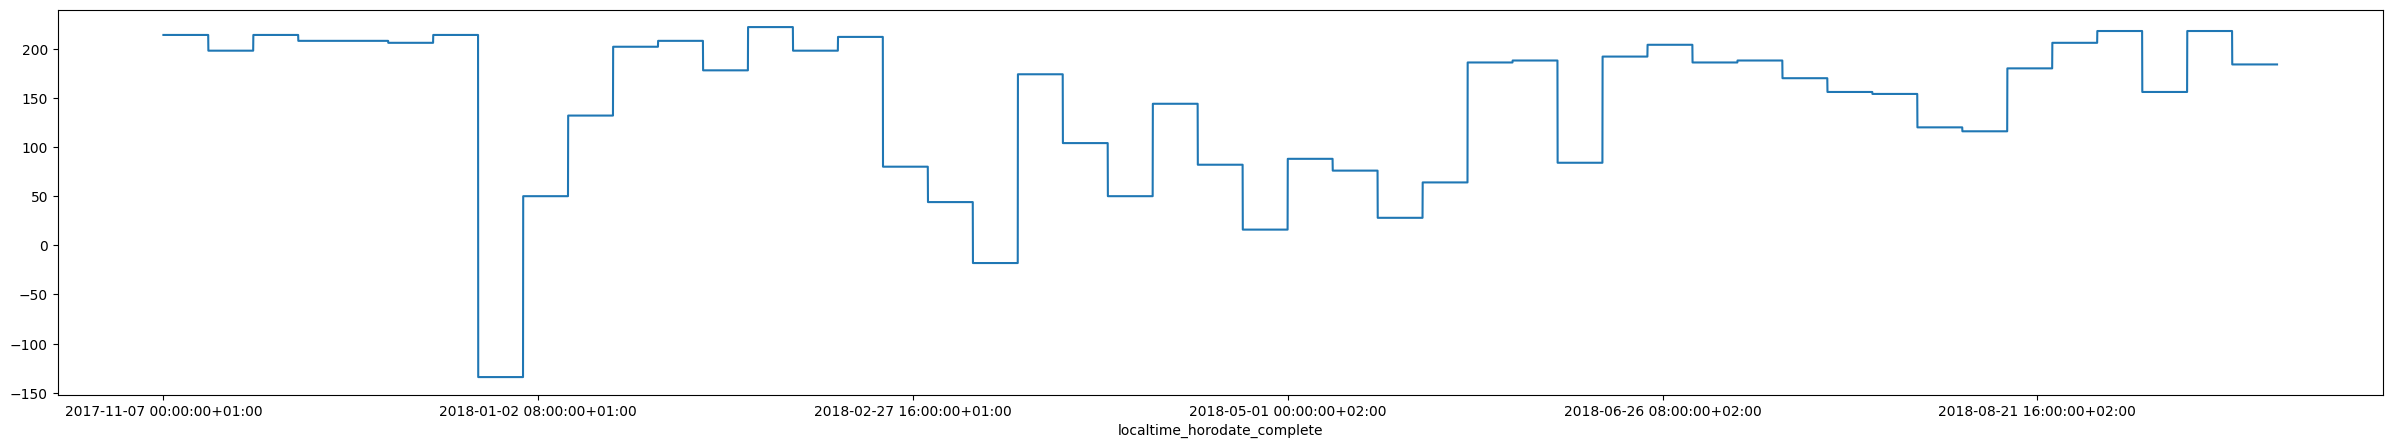

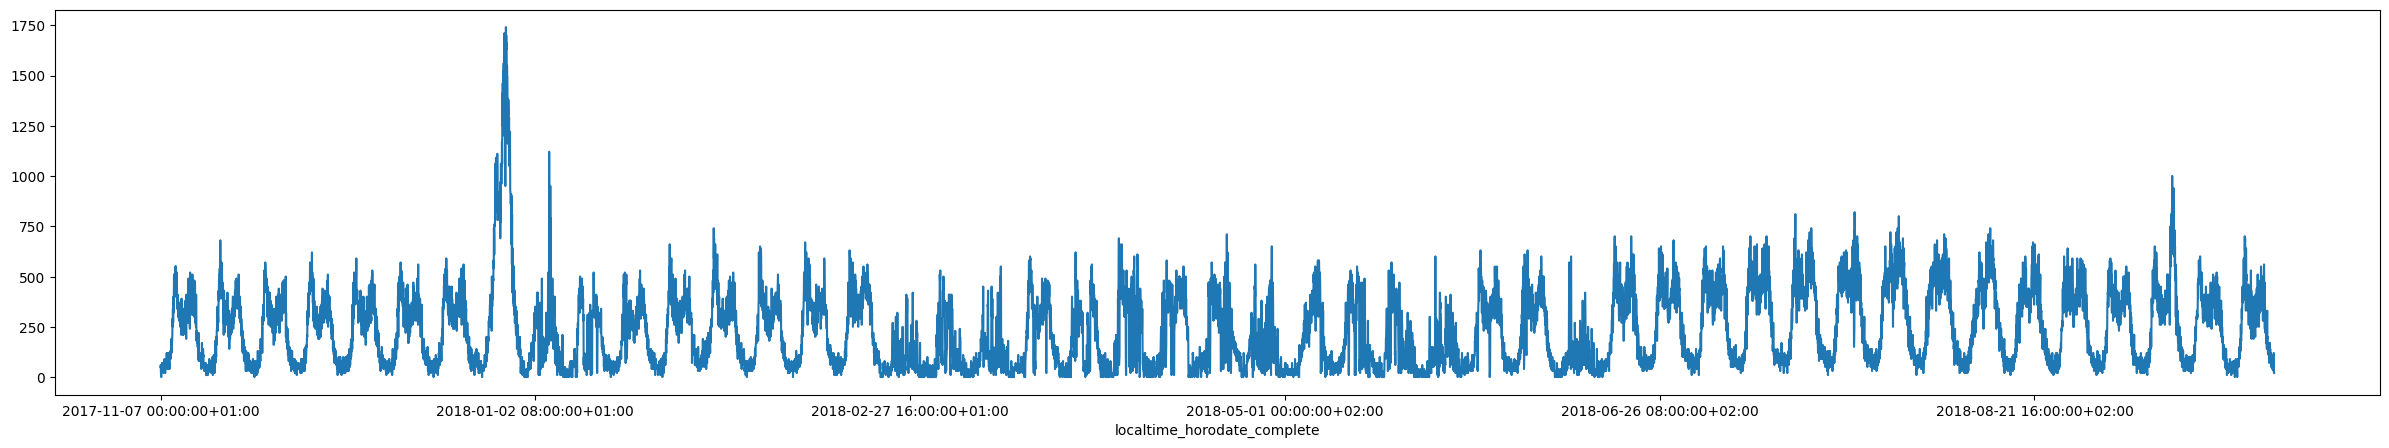

In [78]:
df_plot = df.copy()
df_plot.index = df_plot.index.astype('category')
df_plot.valid_value_sum.plot(figsize=(30, 5))
plt.show()
df_plot.flow.plot(figsize=(30, 5))
plt.show()

On peut se fixer un seuil grossier pour décider quand une date doit être considérée comme outlier. Ajoutez une colonne `date_is_outlier` qui vaut `True` si `valid_value_sum` est inférieure à 100 :

In [79]:
df['date_is_outlier'] = df.valid_value_sum < 100

Quels sont les jours outliers selon notre critère ?

In [80]:
df[df.date_is_outlier].date.unique()

array(['2017-12-26', '2018-01-02', '2018-02-27', '2018-03-06',
       '2018-03-13', '2018-04-03', '2018-04-17', '2018-04-24',
       '2018-05-01', '2018-05-08', '2018-05-15', '2018-05-22',
       '2018-06-12'], dtype=object)

Créez une nouvelle dataframe contenant que le trafic des jours qui ne sont pas outliers puis affichez un graphique des valeurs de `flow` pour cette dataframe :

In [81]:
clean_data = df.loc[df.date_is_outlier == False]

In [83]:
fig = px.line(
    clean_data,
    x=clean_data.index,
    y='flow',
    render_mode='svg'
)

fig.update_xaxes(
    rangebreaks=[
        dict(bounds=["wed", "tues"]),
    ]
)
fig.show(renderer='colab')

Vérifiez que le nettoyage donne une décomposition plus encourageante...

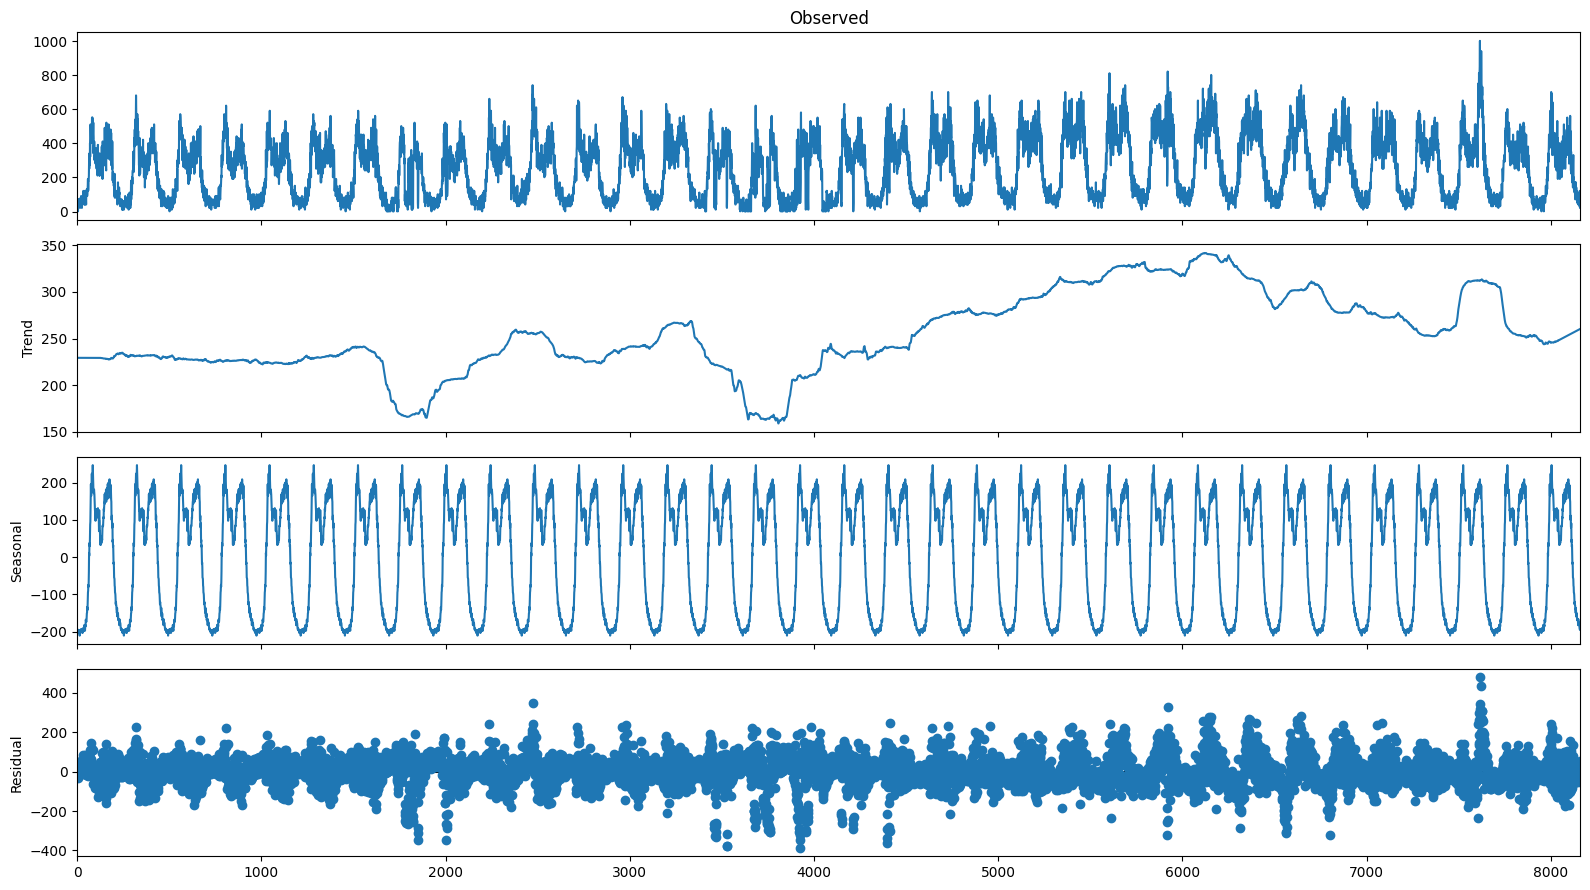

In [84]:
st_result = seasonal_decompose(
    clean_data.flow.values,
    model="additive",
    period=24*10,
    extrapolate_trend=True
)

fig = st_result.plot()
fig.set_size_inches((16, 9))
fig.tight_layout()

Le nettoyage vous paraît-il satisfaisant en vue d'une prédiction par des modèles linéaires (moyenne glissante, sarima, etc.) ? Proposez (et testez !) des modifications simples.